## Eligibility for mobilization - Analysis

Run this script after running the [cohort_identification.ipynb](cohort_identification.ipynb)

## Load libraries 

In [1]:
#! pip install pandas numpy duckdb seaborn matplotlib tableone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import pyCLIF
from tableone import TableOne

Loaded configuration from config.json
{'site_name': 'University of Chicago', 'tables_path': '/Users/williamparker/Desktop/CLIF_tables', 'file_type': 'parquet'}


In [2]:
final_df = pd.read_parquet('../output/intermediate/final_df.parquet')

## Forward and Backward fill the final dataset

In [3]:
# List of columns to fill NAs
# Columns not to fill
exclude_columns = ['hospitalization_id', 'recorded_date', 'recorded_hour', 'time_from_vent', 'time_from_vent_adjusted']

# List of columns to fill NAs (all columns except the excluded ones)
columns_to_fill = [col for col in final_df.columns if col not in exclude_columns]

# Fill NAs forward and backward by hospitalization_id
final_df[columns_to_fill] = final_df.groupby('hospitalization_id')[columns_to_fill].transform(
    lambda x: x.fillna(method='ffill').fillna(method='bfill')
)

# Set 'hospitalization_id' to object (string)
final_df['hospitalization_id'] = final_df['hospitalization_id'].astype(str)

# Convert 'recorded_date' to datetime
final_df['recorded_date'] = pd.to_datetime(final_df['recorded_date']).dt.date

# Replace NAs with 0 for med flags columns
final_df[['red_meds_flag']] = final_df[['red_meds_flag']].fillna(0)
# Columns to set as int64
int64_columns = [
    'recorded_hour',
    'time_from_vent',
    'time_from_vent_adjusted',
    'hourly_trach',
    'hourly_on_vent',
    'red_meds_flag'
]

# Convert specified columns to int64
final_df[int64_columns] = final_df[int64_columns].astype('int64')

# Set all other variables to float64
exclude_columns_for_float = ['hospitalization_id', 'recorded_date'] + int64_columns
float64_columns = [col for col in final_df.columns if col not in exclude_columns_for_float]
final_df[float64_columns] = final_df[float64_columns].astype('float64')


/var/folders/hb/bldfxw_11b1fxzs4m1sc_5xh0000gp/T/ipykernel_72731/2192766727.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')
/var/folders/hb/bldfxw_11b1fxzs4m1sc_5xh0000gp/T/ipykernel_72731/2192766727.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')


In [4]:
# checkpoint- useful to compare to the original df and check filling logic
final_df.to_parquet(f'../output/intermediate/final_df_filled_{datetime.now().strftime("%Y%m%d%H%M%S")}.parquet')

## Create Criteria Flags

### Patel et al. Criteria:

Cardio
* Mean arterial blood pressure: 65-110 mm Hg
* Systolic blood pressure: ≤ 200 mm Hg
* Heart rate: 40-130 beats per minute

Respiratory
* Respiratory rate: 5-40 breaths per minute
* Pulse oximetry: ≥ 88%

In [5]:
# Apply Patel et al. Criteria

# 1. Mean arterial blood pressure: 65-110 mm Hg
final_df['patel_map_flag'] = (
    (final_df['min_map'] >= 65) & (final_df['max_map'] <= 110)
).astype(int)

# 2. Systolic blood pressure: ≤ 200 mm Hg
final_df['patel_sbp_flag'] = (
    final_df['max_sbp'] <= 200
).astype(int)

# 3. Heart rate (Pulse): 40-130 beats per minute
final_df['patel_pulse_flag'] = (
    (final_df['min_heart_rate'] >= 40) & (final_df['max_heart_rate'] <= 130)
).astype(int)

# 4. Respiratory rate: 5-40 breaths per minute
final_df['patel_resp_rate_flag'] = (
    (final_df['min_respiratory_rate'] >= 5) & (final_df['max_respiratory_rate'] <= 40)
).astype(int)

# 5. Pulse oximetry (SpO2): ≥ 88%
final_df['patel_spo2_flag'] = (
    final_df['min_spo2'] >= 88
).astype(int)

# Resp flag: Combines respiratory rate and SpO2 criteria
final_df['patel_resp_flag'] = (
    final_df['patel_resp_rate_flag'] &
    final_df['patel_spo2_flag']
).astype(int)

# Cardio flag: Combines MAP, SBP, and Pulse criteria
final_df['patel_cardio_flag'] = (
    final_df['patel_map_flag'] &
    final_df['patel_sbp_flag'] &
    final_df['patel_pulse_flag']
).astype(int)

# Step 2: Create the overall Patel flag
final_df['patel_flag'] = (
    final_df['patel_map_flag'] &
    final_df['patel_sbp_flag'] &
    final_df['patel_pulse_flag'] &
    final_df['patel_resp_rate_flag'] &
    final_df['patel_spo2_flag']
)

### TEAM criteria

Cardio
* Heart rate: ≤ 150 bpm
* Most recent lactate: ≤ 4.0 mmol/L
* Noradrenaline infusion rate: 0.1-0.2 mcg/kg/min (inclusive)- I used calculated NE for this. 

Respiratory
* Sufficient respiratory stability:
    *  FiO2: ≤ 0.6
    *  PEEP: ≤ 16 cm H2O (use peep_observed)
* Current respiratory rate: ≤ 45 (use resp_rate_obs)

In [6]:
# 1. Heart rate: ≤ 150 bpm
final_df['team_pulse_flag'] = (
    final_df['max_heart_rate'] <= 150
).astype(int)

# 2. Most recent lactate: ≤ 4.0 mmol/L
final_df['team_lactate_flag'] = (
    final_df['lactate'] <= 4.0
).astype(int)

# 3. Noradrenaline infusion rate: 0.1-0.2 mcg/kg/min
final_df['team_ne_flag'] = (
    # (final_df['ne_calc_min'] >= 0.1) & (final_df['ne_calc_max'] <= 0.2)
    final_df['ne_calc_max'] <= 0.2
).astype(int)

# 4. Sufficient respiratory stability:
#    a. FiO2: ≤ 0.6
final_df['team_fio2_flag'] = (
    final_df['min_fio2_set'] <= 0.6
).astype(int)

#    b. PEEP: ≤ 16 cm H2O
final_df['team_peep_flag'] = (
    final_df['max_peep_set'] <= 16
).astype(int)

# 5. Current respiratory rate: ≤ 45
final_df['team_resp_rate_flag'] = (
    final_df['max_resp_rate_obs'] <= 45
).astype(int)

# Cardio flag: Combines heart rate, lactate, and norepinephrine criteria
final_df['team_cardio_flag'] = (
    final_df['team_pulse_flag'] &
    final_df['team_lactate_flag'] &
    final_df['team_ne_flag']
).astype(int)

# Resp flag: Combines FiO2, PEEP, and respiratory rate criteria
final_df['team_resp_flag'] = (
    final_df['team_fio2_flag'] &
    final_df['team_peep_flag'] &
    final_df['team_resp_rate_flag']
).astype(int)


# Step 2: Create the overall TEAM flag
final_df['team_flag'] = (
    final_df['team_pulse_flag'] &
    final_df['team_lactate_flag'] &
    final_df['team_ne_flag'] &
    final_df['team_fio2_flag'] &
    final_df['team_peep_flag'] &
    final_df['team_resp_rate_flag']
)

### Consensus criteria

* Green Criteria
    * Respiratory
        * Saturation  90% and
        * Respiratory rate ≤ 30 breaths/min
        * Current FiO2 ≤ 0.6 and
        * PEEP≤ 10cm H20
    * Cardiovascular:
        * Blood pressure greater than lower limit of target range (MAP 65+) while on no or low level of support (low support- define as <0.1 μg/kg/min of Norepi equivalents)
        * Heart rate <120 beats/min
        * lactate < 4mmol/L
        * HR > 40
* Yellow Criteria
    * Respiratory
        * Sat >= 90%
        * Current FiO2 >0.6
        * Respiratory rate >30breaths/min
        * PEEP >10cm H20
    * Cardiovascular
        * Blood pressure greater than lower limit of target range (MAP 65+) while receiving moderate level of support (medium-define as 0.1–0.3 μg/kg/min of Norepi equivalents)
        * Heart rate 120-150 beats/min
        * Shock of any cause with lactate >4mmol/L
        * HR > 40
* Red Criteria
    * Respiratory
        * Sat <90%
    * Cardiovascular
        * Below target MAP despite support (MAP <65) or
        * greater than lower limit MAP (MAP 65+) but on high level support (high defined as >0.3 μg/kg/min of Norepi equivalents)
        * IV therapy for hypertensive emergency (SBP >200mmHg or MAP >110 and on nicardipine, nitroprusside, or clevidipine gtt)
        * HR >150 bpm
        * Bradycardia <40


### Consensus criteria - redefined 

* all_red: All red subcomponents must be met.
* all_green: All green subcomponents must be met, and no red subcomponents are met.
* all_yellow: All yellow subcomponents must be met, no red subcomponents are met, and all green subcomponents are not met.
* any_yellow: Any yellow subcomponent is met, no green subcomponents are fully met, and no red subcomponents are met.
* any_yellow_or_green_no_red: Any yellow or green subcomponents are met, but no red subcomponents are met.

In [7]:
# Red Cardiovascular Criteria
final_df['red_resp_spo2_flag'] = (final_df['min_spo2'] < 90).astype(int)
final_df['red_map_flag'] = (final_df['min_map'] < 65).astype(int)
# High support (Norepinephrine equivalents > 0.3 μg/kg/min)
final_df['red_high_support_flag'] = (final_df['ne_calc_max'] > 0.3).astype(int)
# Hypertensive emergency criteria (SBP > 200 mmHg or MAP > 110 mmHg and on certain medications)
final_df['red_hypertensive_flag'] = (
    ((final_df['max_sbp'] > 200) | (final_df['max_map'] > 110)) &
    (final_df['red_meds_flag'] == 1)
).astype(int)
# High heart rate criteria (HR > 150 bpm)
final_df['red_pulse_high_flag'] = (final_df['max_heart_rate'] > 150).astype(int)
# Low heart rate criteria (HR < 40 bpm)
final_df['red_pulse_low_flag'] = (final_df['min_heart_rate'] < 40).astype(int)

# Yellow Respiratory Criteria
final_df['yellow_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
final_df['yellow_fio2_flag'] = (final_df['min_fio2_set'] > 0.6).astype(int)
final_df['yellow_resp_rate_flag'] = (final_df['max_resp_rate_obs'] > 30).astype(int)
final_df['yellow_peep_flag'] = (final_df['min_peep_set'] > 10).astype(int)

# Yellow Cardiovascular Criteria
final_df['yellow_map_flag'] = (final_df['min_map'] >= 65).astype(int) & (final_df['ne_calc_max'].between(0.1, 0.3)).astype(int)
final_df['yellow_pulse_flag'] = (final_df['min_heart_rate'].between(120, 150)).astype(int)
final_df['yellow_lactate_flag'] = (final_df['lactate'] > 4).astype(int)

# Step 3: Implement Green Criteria
final_df['green_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
final_df['green_resp_rate_flag'] = (final_df['max_resp_rate_obs'] <= 30).astype(int)
final_df['green_fio2_flag'] = (final_df['min_fio2_set'] <= 0.6).astype(int)
final_df['green_peep_flag'] = (final_df['min_peep_set'] <= 10).astype(int)

# Green Cardiovascular Criteria
final_df['green_map_flag'] = (final_df['min_map'] >= 65).astype(int) & (final_df['ne_calc_max'] < 0.1).astype(int)
final_df['green_pulse_flag'] = (final_df['min_heart_rate'] < 120).astype(int)
final_df['green_lactate_flag'] = (final_df['lactate'] < 4).astype(int)
final_df['green_hr_flag'] = (final_df['min_heart_rate'] > 40).astype(int)

final_df['any_red'] = (
    final_df['red_resp_spo2_flag'] |
    final_df['red_map_flag'] |
    final_df['red_high_support_flag'] |
    final_df['red_hypertensive_flag'] |
    final_df['red_pulse_high_flag'] |
    final_df['red_pulse_low_flag']
).astype(int)

final_df['any_yellow'] = (
    (
        final_df['yellow_resp_spo2_flag'] |
        final_df['yellow_fio2_flag'] |
        final_df['yellow_resp_rate_flag'] |
        final_df['yellow_peep_flag'] |
        final_df['yellow_map_flag'] |
        final_df['yellow_pulse_flag'] |
        final_df['yellow_lactate_flag']
    )
).astype(int)

final_df['any_green'] = (
    final_df['green_resp_spo2_flag'] |
    final_df['green_resp_rate_flag'] |
    final_df['green_fio2_flag'] |
    final_df['green_peep_flag'] |
    final_df['green_map_flag'] |
    final_df['green_pulse_flag'] |
    final_df['green_lactate_flag'] |
    final_df['green_hr_flag'] 
).astype(int)


final_df['all_green'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] 
).astype(int)

final_df['all_green_no_red'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] &
    (final_df['any_red'] == 0)  # Ensure no red subcomponents are met
).astype(int)

final_df['all_green_no_red_yellow'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] &
    (final_df['any_red'] == 0)  & # Ensure no red subcomponents are met
    (final_df['any_yellow'] == 0)  # Ensure no yellow subcomponents are met
).astype(int)


# Define 'all_yellow_only' (all yellow subcomponents must be met, no red subcomponents, and no green subcomponents)
final_df['all_yellow_no_red_green'] = (
    final_df['yellow_resp_spo2_flag'] &
    final_df['yellow_fio2_flag'] &
    final_df['yellow_resp_rate_flag'] &
    final_df['yellow_peep_flag'] &
    final_df['yellow_map_flag'] &
    final_df['yellow_pulse_flag'] &
    final_df['yellow_lactate_flag'] &
    (final_df['any_red'] == 0) &  # Ensure no red subcomponents are met
    (final_df['any_green'] == 0)  # Ensure no green subcomponents are fully met
).astype(int)

#  Define 'any_yellow_only' (any yellow subcomponent is met, no green or red subcomponents are met)
final_df['any_yellow_no_red_green'] = (
    (
        final_df['yellow_resp_spo2_flag'] |
        final_df['yellow_fio2_flag'] |
        final_df['yellow_resp_rate_flag'] |
        final_df['yellow_peep_flag'] |
        final_df['yellow_map_flag'] |
        final_df['yellow_pulse_flag'] |
        final_df['yellow_lactate_flag']
    ) &
    (final_df['any_red'] == 0) &  # Ensure no red subcomponents are met
    (final_df['any_green'] == 0)  # Ensure no green subcomponents are fully met
).astype(int)

# Define 'any_yellow_or_green' (any yellow or green subcomponent is met, but no red subcomponents are met)
final_df['any_yellow_or_green_no_red'] = (
    (
        final_df['yellow_resp_spo2_flag'] |
        final_df['yellow_fio2_flag'] |
        final_df['yellow_resp_rate_flag'] |
        final_df['yellow_peep_flag'] |
        final_df['yellow_map_flag'] |
        final_df['yellow_pulse_flag'] |
        final_df['yellow_lactate_flag'] |
        final_df['green_resp_spo2_flag'] |
        final_df['green_resp_rate_flag'] |
        final_df['green_fio2_flag'] |
        final_df['green_peep_flag'] |
        final_df['green_map_flag'] |
        final_df['green_pulse_flag'] |
        final_df['green_lactate_flag'] |
        final_df['green_hr_flag']
    ) &
    (final_df['any_red'] == 0)   # Ensure no red subcomponents are met
).astype(int)

final_df['yellow_resp_flag'] = (
    (
     final_df['yellow_resp_spo2_flag'] |
     final_df['yellow_fio2_flag'] |
     final_df['yellow_resp_rate_flag'] |
     final_df['yellow_peep_flag'] |
     final_df['green_resp_spo2_flag'] |
     final_df['green_resp_rate_flag'] |
     final_df['green_fio2_flag'] |
     final_df['green_peep_flag'] 
    )  &
    (final_df['any_red'] == 0)  # Ensure no red subcomponents are met
).astype(int)

final_df['yellow_cardio_flag'] = (
    (
    final_df['yellow_map_flag'] |
    final_df['yellow_pulse_flag'] |
    final_df['yellow_lactate_flag'] |
    final_df['green_map_flag'] |
    final_df['green_pulse_flag'] |
    final_df['green_lactate_flag'] |
    final_df['green_hr_flag']
    )&
    (final_df['any_red'] == 0)  # Ensure no red subcomponents are met
).astype(int)

# Group where all green subcomponents are met and no red or yellow criteria are met
final_df['yellow_all_green'] = (
    final_df['all_green_no_red'] &  # All green subcomponents are met with no red
    (final_df['any_yellow'] == 0)   # Ensure no yellow subcomponents are met
).astype(int)

# Group where 'any_yellow_or_green_no_red' is met, but it's not all green (some yellow components are met)
final_df['yellow_not_all_green'] = (
    final_df['any_yellow_or_green_no_red'] &  # Meets the yellow or green criteria with no red
    (final_df['all_green_no_red'] == 0)       # Ensure it does not meet all green criteria
).astype(int)

In [8]:
# Optional: To summarize the results, you can print value counts for each flag
print(final_df[['any_red', 'any_yellow', 'any_green' ,  'all_green',
                'all_green_no_red', 'all_green_no_red_yellow', 'all_yellow_no_red_green', 
                'any_yellow_no_red_green','any_yellow_or_green_no_red','yellow_all_green',
                 'yellow_not_all_green' ]].sum())

any_red                        310510
any_yellow                    2604899
any_green                     2631284
all_green                     1126155
all_green_no_red              1108881
all_green_no_red_yellow             0
all_yellow_no_red_green             0
any_yellow_no_red_green             0
any_yellow_or_green_no_red    2320774
yellow_all_green                    0
yellow_not_all_green          1211893
dtype: int64


## TableOne

In [9]:
patient = pyCLIF.load_data('clif_patient')
hospitalization = pyCLIF.load_data('clif_hospitalization')
patient = pyCLIF.remove_duplicates(patient, ['patient_id'], 'patient')
hospitalization = pyCLIF.remove_duplicates(hospitalization, ['hospitalization_id'], 'hospitalization')

Data loaded successfully from /Users/williamparker/Desktop/CLIF_tables/clif_patient.parquet
Data loaded successfully from /Users/williamparker/Desktop/CLIF_tables/clif_hospitalization.parquet
Processing DataFrame: patient
No duplicates found based on columns: ['patient_id'].
Processing DataFrame: hospitalization
No duplicates found based on columns: ['hospitalization_id'].


In [10]:
columns_to_keep = ['hospitalization_id','recorded_date', 'recorded_hour', 
                   'patel_flag', 'team_flag', 'any_yellow_or_green_no_red',
                   'ne_calc_min', 'max_peep_set', 'min_fio2_set']
final_df_table1 = final_df[columns_to_keep]
final_df_table1 = pd.merge(final_df_table1, hospitalization, how = 'left' , on='hospitalization_id')
final_df_table1 = pd.merge(final_df_table1, patient, how = 'left' , on='patient_id')
# final_df_table1 = pyCLIF.map_race_column(final_df, 'race_category')

In [11]:
final_df_table1.value_counts('race_category')

race_category
Black or African American                    1640260
White                                         675010
Unknown                                       144236
Other                                         101808
Asian                                          54706
American Indian or Alaska Native                7843
Native Hawaiian or Other Pacific Islander       6071
Name: count, dtype: int64

In [12]:
## confirm mapping here
final_df_table1 = pyCLIF.map_race_column(final_df_table1, 'race_category')
final_df_table1.value_counts('race_new')

race_new
Black      1640260
White       675010
Other       314664
Missing       1351
Name: count, dtype: int64

In [13]:
# Define the variables to include in the table
# Categorical variables
categorical = ['sex_category', 'race_new']

# Continuous variables
continuous = ['age_at_admission']

# If you have 'ne_calc_min', 'max_peep_set', 'min_fio2_set' in your dataframe, include them
# For the sake of completeness, I'll assume these variables are present
# If they are not, you can exclude them or replace them with the correct variable names
additional_continuous = ['ne_calc_min', 'max_peep_set', 'min_fio2_set']

# Check if these additional variables are in your DataFrame
variables_to_check = additional_continuous
variables_present = [var for var in variables_to_check if var in final_df_table1.columns]

# Update the continuous variables list
continuous += variables_present

# All variables to include in the table
columns = categorical + continuous

# Create subsets based on criteria
result_patel = final_df_table1[final_df_table1['patel_flag'] == 1].copy()
result_team = final_df_table1[final_df_table1['team_flag'] == 1].copy()
result_yellow = final_df_table1[final_df_table1['any_yellow_or_green_no_red'] == 1].copy()

# Add a 'Criteria' column to each subset
result_patel['Criteria'] = 'Patel Criteria'
result_team['Criteria'] = 'TEAM Criteria'
result_yellow['Criteria'] = 'Yellow Criteria'

# Combine all dataframes
combined_df = pd.concat([final_df_table1, result_patel, result_team, result_yellow], ignore_index=True)

# Remove duplicates to ensure each hospitalization_id appears only once per criteria
combined_df = combined_df.drop_duplicates(subset=['hospitalization_id', 'Criteria'])

# Now, create the TableOne object
table1 = TableOne(
    combined_df,
    columns=columns,
    categorical=categorical,
    groupby='Criteria',
    pval=False,
    missing=False
)

# Print the table
# print(table1.tabulate(tablefmt="fancy_grid"))
table1

Grouped by Criteria                                             
                                                Overall Patel Criteria TEAM Criteria Yellow Criteria
n                                                 26872           7547          4133            7438
sex_category, n (%)         Female         10888 (40.5)    3076 (40.8)   1599 (38.7)     3032 (40.8)
                            Male           15984 (59.5)    4471 (59.2)   2534 (61.3)     4406 (59.2)
race_new, n (%)             Black          16957 (63.1)    4793 (63.5)   2506 (60.6)     4720 (63.5)
                            Missing            40 (0.1)       10 (0.1)       7 (0.2)        11 (0.1)
                            Other           3339 (12.4)     930 (12.3)    534 (12.9)      915 (12.3)
                            White           6536 (24.3)    1814 (24.0)   1086 (26.3)     1792 (24.1)
age_at_admission, mean (SD)                 57.4 (17.4)    57.2 (17.4)   58.1 (17.0)     57.2 (17.4)
ne_calc_min, mean (SD)                       2.0 (27.6)     4.5 (42.0)     0.1 (0.1)       0.1 (0.1)
max_peep_set, mean (SD)                       5.6 (1.8)      5.6 (1.8)     5.6 (1.7)       5.6 (1.8)
min_fio2_set, mean (SD)                       0.6 (0.2)      0.6 (0.2)     0.5 (0.1)       0.6 (0.2)

## Restrict to business hours in the first 72 hours after intubation*

* 4-hour cool off period after first intubation

In [14]:
business_hours_df = final_df[(final_df['time_from_vent_adjusted'] >= 0) & (final_df['time_from_vent_adjusted'] < 72)]
business_hours_df = business_hours_df[(business_hours_df['recorded_hour'] >= 8) & (business_hours_df['recorded_hour'] < 17)].copy()
business_hours_df['time_biz'] = business_hours_df.groupby('hospitalization_id').cumcount()

## Final figures and tables

1. Figure 1: Percentage of encounter satisfying Patel, TEAM, and any yellow or GREEN criteria
2. Figure 2: Percentage of business hours each encounter was eligible for different criteria
3. Figure 3: Percentage of business hours not eligible for each criteria broken down by subcomponent failure


### Eligibility by encounter

In [15]:
def count_encounters_meeting_criteria(df):
    total_encounters = df['hospitalization_id'].nunique()  # Calculate total unique encounters
    # For each encounter, check if they ever met the criteria and sum up
    criteria_counts = df.groupby('hospitalization_id').agg(
        patel_met=('patel_flag', lambda x: x.max()),
        team_met=('team_flag', lambda x: x.max()),
        any_yellow_or_green_no_red_met=('any_yellow_or_green_no_red', lambda x: x.max())
    ).sum().reset_index()

    criteria_counts.columns = ['Criteria', 'Number of Encounters']
    criteria_counts['Percentage'] = (criteria_counts['Number of Encounters'] / total_encounters) * 100
    
    return criteria_counts

# Generate the criteria comparison table

criteria_comparison_table = count_encounters_meeting_criteria(business_hours_df)
criteria_comparison_table['site_name'] = pyCLIF.helper["site_name"]
pd.DataFrame(criteria_comparison_table).to_csv(f'../output/final/eligibility_by_hosp_{pyCLIF.helper["site_name"]}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv',index=False)
criteria_comparison_table

,Criteria,Number of Encounters,Percentage,site_name
0,patel_met,7386,97.814859,University of Chicago
1,team_met,3923,51.953384,University of Chicago
2,any_yellow_or_green_no_red_met,7229,95.735664,University of Chicago


/var/folders/hb/bldfxw_11b1fxzs4m1sc_5xh0000gp/T/ipykernel_72731/1300807749.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Criteria', y='Percentage', data=criteria_comparison_table, palette=custom_colors)


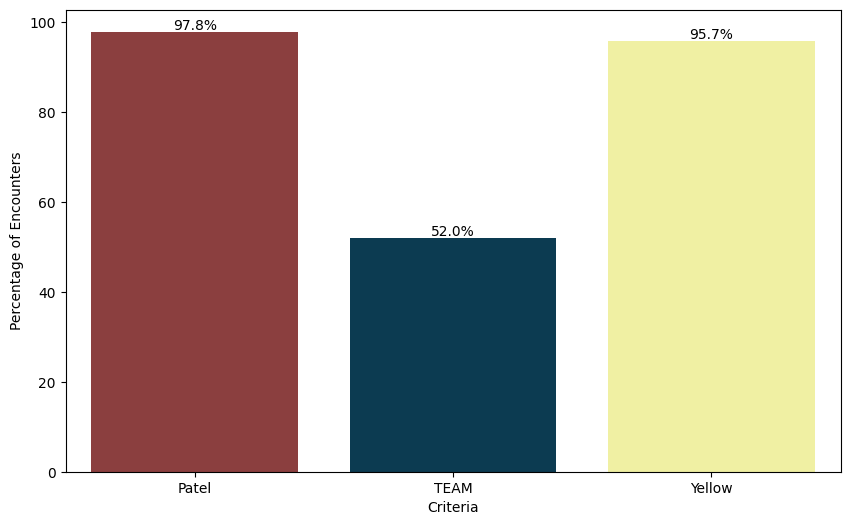

In [16]:
# Rename the criteria for clarity
criteria_comparison_table['Criteria'] = criteria_comparison_table['Criteria'].replace({
    'patel_met': 'Patel',
    'team_met': 'TEAM',
    'any_yellow_or_green_no_red_met': 'Yellow'
})

# Define custom colors
custom_colors = ['#983232', '#003f5c', '#fdfd96']  # Maroon, Dark Blue, Pastel Yellow

# Plot the bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Criteria', y='Percentage', data=criteria_comparison_table, palette=custom_colors)

# Rotate the x-axis labels
# plt.xticks(rotation=90)

# Add percentages on top of the bars
for index, row in criteria_comparison_table.iterrows():
    barplot.text(index, row['Percentage'] + 0.5, f"{row['Percentage']:.1f}%", 
                 color='black', ha="center")

# Add labels and title
plt.xlabel('Criteria')
plt.ylabel('Percentage of Encounters')
# plt.title('Percentage of Encounters Meeting Each Criterion')a

plt.show()

### Eligibility by business hour

In [17]:
# Function to compute the percentage of business hours
def compute_percentage_hours_by_criteria(df, criteria_columns):
    """
    Compute the percentage of business hours each encounter was eligible for different criteria.
    """
    # Calculate the total number of business hours per encounter
    total_business_hours = df.groupby('hospitalization_id')['time_biz'].max()
    # Filter out encounters with zero business hours to avoid division by zero
    total_business_hours = total_business_hours[total_business_hours > 0]
    # Sum the number of hours each criterion is met for each encounter
    hours_criteria = df.groupby('hospitalization_id').agg({criterion: 'sum' for criterion in criteria_columns})
    # Retain only the encounters with non-zero business hours
    hours_criteria = hours_criteria.loc[total_business_hours.index]
    # Calculate the percentage of business hours met for each criterion
    percentage_hours_by_criteria = hours_criteria.divide(total_business_hours, axis=0) * 100
    # Calculate the mean percentage of hours met for each criterion across all encounters
    avg_percentage_by_criteria = percentage_hours_by_criteria.mean().reset_index()
    avg_percentage_by_criteria.columns = ['Criteria', 'Average Percentage of Hours Met']
    return avg_percentage_by_criteria

# Define the mapping for the criteria
criteria_columns = ['patel_flag', 'team_flag', 'any_yellow_or_green_no_red']
criteria_mapping = {
    'patel_flag': 'Patel',
    'team_flag': 'TEAM',
    'any_yellow_or_green_no_red': 'Yellow'
}

# Calculate the percentage of business hours met for each criterion
avg_percentage_by_criteria = compute_percentage_hours_by_criteria(business_hours_df, criteria_columns)

# Replace the criteria names according to the mapping
avg_percentage_by_criteria['Criteria'] = avg_percentage_by_criteria['Criteria'].replace(criteria_mapping)
avg_percentage_by_criteria['site_name'] = pyCLIF.helper["site_name"]
pd.DataFrame(avg_percentage_by_criteria).to_csv(f'../output/final/eligibility_by_hour_{pyCLIF.helper["site_name"]}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv',index=False)
avg_percentage_by_criteria


,Criteria,Average Percentage of Hours Met,site_name
0,Patel,78.926736,University of Chicago
1,TEAM,43.810109,University of Chicago
2,Yellow,82.660370,University of Chicago


/var/folders/hb/bldfxw_11b1fxzs4m1sc_5xh0000gp/T/ipykernel_72731/676592903.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Criteria', y='Average Percentage of Hours Met', data=avg_percentage_by_criteria, palette=custom_colors)


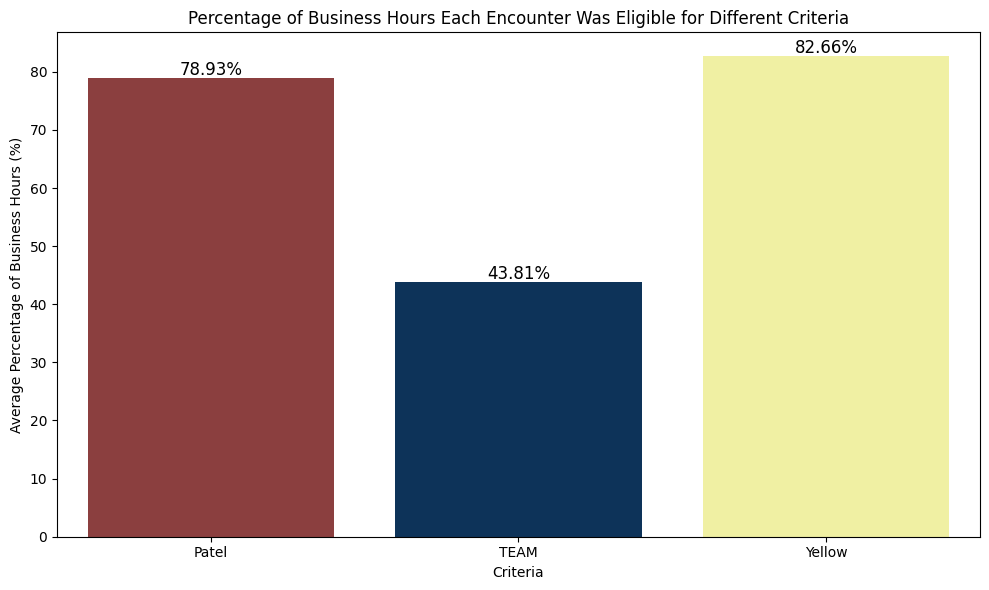

In [18]:
# Create the bar plot
plt.figure(figsize=(10, 6))

# Custom colors for each criterion: Patel (Maroon), TEAM (Dark Blue), Yellow (Pastel Yellow)
custom_colors = ['#983232', '#003366', '#fdfd96']

ax = sns.barplot(x='Criteria', y='Average Percentage of Hours Met', data=avg_percentage_by_criteria, palette=custom_colors)

# Add the percentage as labels on top of the bars
for i, row in avg_percentage_by_criteria.iterrows():
    ax.text(i, row['Average Percentage of Hours Met'] + 0.5, f'{row["Average Percentage of Hours Met"]:.2f}%', 
            ha='center', color='black', fontsize=12)

# Customize the plot
plt.title('Percentage of Business Hours Each Encounter Was Eligible for Different Criteria')
plt.xlabel('Criteria')
plt.ylabel('Average Percentage of Business Hours (%)')

# Show the plot
plt.tight_layout()
plt.show()

### Failure by subcomponents

In [19]:
import pandas as pd
import plotly.graph_objects as go

# Define your criteria and corresponding subcomponent flags
criteria_info = {
    'patel_flag': {'resp_flag': 'patel_resp_flag', 'cardio_flag': 'patel_cardio_flag'},
    'team_flag': {'resp_flag': 'team_resp_flag', 'cardio_flag': 'team_cardio_flag'},
    'any_yellow_or_green_no_red': {'resp_flag': 'yellow_resp_flag', 'cardio_flag': 'yellow_cardio_flag'}
}

# Initialize an empty list to store results
results = []

# Loop over each criterion
for criterion, flags in criteria_info.items():
    resp_flag = flags['resp_flag']
    cardio_flag = flags['cardio_flag']
    
    # Calculate total hours per hospitalization_id
    total_hours = final_df.groupby('hospitalization_id').size().rename('total_hours')
    
    # Create failure indicators
    df_failure = final_df.copy()
    df_failure['resp_only_failure'] = ((df_failure[resp_flag] == 0) & (df_failure[cardio_flag] == 1)).astype(int)
    df_failure['cardio_only_failure'] = ((df_failure[resp_flag] == 1) & (df_failure[cardio_flag] == 0)).astype(int)
    df_failure['both_failures'] = ((df_failure[resp_flag] == 0) & (df_failure[cardio_flag] == 0)).astype(int)
    
    # Aggregate the counts per hospitalization_id
    failure_counts = df_failure.groupby('hospitalization_id')[['resp_only_failure', 'cardio_only_failure', 'both_failures']].sum()
    
    # Merge with total hours
    failure_counts = failure_counts.merge(total_hours, left_index=True, right_index=True)
    
    # Calculate percentages
    failure_counts['resp_only_failure_perc'] = (failure_counts['resp_only_failure'] * 100 / failure_counts['total_hours']).round(3)
    failure_counts['cardio_only_failure_perc'] = (failure_counts['cardio_only_failure'] * 100 / failure_counts['total_hours']).round(3)
    failure_counts['both_failures_perc'] = (failure_counts['both_failures'] * 100 / failure_counts['total_hours']).round(3)
    
    # Calculate total failure percentage
    failure_counts['total_failure_perc'] = (
        failure_counts['resp_only_failure'] + failure_counts['cardio_only_failure'] + failure_counts['both_failures']
    ) * 100 / failure_counts['total_hours']
    
    # Calculate criterion met percentage
    criterion_met = final_df.groupby('hospitalization_id')[criterion].sum().rename('criterion_met_hours')
    failure_counts = failure_counts.merge(criterion_met, left_index=True, right_index=True)
    failure_counts['criterion_met_perc'] = (failure_counts['criterion_met_hours'] * 100 / failure_counts['total_hours']).round(3)
    
    # Add criterion name to the DataFrame
    failure_counts['Criteria'] = criterion
    
    # Append to results
    results.append(failure_counts.reset_index())

# Concatenate results for all criteria
all_failure_counts = pd.concat(results, ignore_index=True)

# Now, calculate the average percentages across all hospitalizations for each criterion
avg_failure_percentages = all_failure_counts.groupby('Criteria').agg({
    'resp_only_failure_perc': 'mean',
    'cardio_only_failure_perc': 'mean',
    'both_failures_perc': 'mean',
    'total_failure_perc': 'mean',
    'criterion_met_perc': 'mean'
}).reset_index()

# Rename columns for clarity
avg_failure_percentages = avg_failure_percentages.rename(columns={
    'resp_only_failure_perc': 'Resp Failure Only',
    'cardio_only_failure_perc': 'Cardio Failure Only',
    'both_failures_perc': 'Both Failures',
    'total_failure_perc': 'Total Failure',
    'criterion_met_perc': 'Criterion Met'
})

# Display the average failure percentages
criteria_mapping = {
    'patel_flag': 'Patel',
    'team_flag': 'TEAM',
    'any_yellow_or_green_no_red': 'Yellow'
}

avg_failure_percentages['Criteria'] = avg_failure_percentages['Criteria'].replace(criteria_mapping)
avg_failure_percentages['site_name'] = pyCLIF.helper["site_name"]
pd.DataFrame(avg_failure_percentages).to_csv(f'../output/final/avg_failure_percentages_{pyCLIF.helper["site_name"]}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv',index=False)
avg_failure_percentages

,Criteria,Resp Failure Only,Cardio Failure Only,Both Failures,Total Failure,Criterion Met,site_name
0,Yellow,0.000000,0.025793,19.197901,19.223702,80.802099,University of Chicago
1,Patel,2.031507,17.068723,3.452836,22.553067,77.446927,University of Chicago
2,TEAM,2.505174,45.622187,7.591421,55.718782,44.281216,University of Chicago


In [20]:
fig = go.Figure()

# Add bars for each criterion
fig.add_trace(go.Bar(
    x=avg_failure_percentages['Criteria'],
    y=avg_failure_percentages['Criterion Met'],
    marker=dict(color=avg_failure_percentages['Criteria'].map({
        'Yellow': '#fdfd96',
        'Patel': '#983232',
        'TEAM': '#003366'
    })),  # Custom colors
    text=avg_failure_percentages['Criterion Met'].round(2),
    textposition='auto'
))

# Customize the layout
fig.update_layout(
    # title='Average Percentage of Business Hours Each Criterion Is Met',
    xaxis_title='Criteria',
    yaxis_title='Average Percentage of Business Hours Met (%)',
    yaxis=dict(range=[0, 100]),  # Ensure y-axis range is 0-100%
    template='plotly_white'
)

# Show the plot
fig.show()

In [21]:
# Create a stacked bar plot using Plotly
fig = go.Figure()

# Add bars for Cardio Failure Only
fig.add_trace(go.Bar(
    x=avg_failure_percentages['Criteria'],
    y=avg_failure_percentages['Cardio Failure Only'],
    name='Cardio Failure Only',
    marker_color='#003366'  # Dark Blue
))

# Add bars for Resp Failure Only
fig.add_trace(go.Bar(
    x=avg_failure_percentages['Criteria'],
    y=avg_failure_percentages['Resp Failure Only'],
    name='Resp Failure Only',
    marker_color='#983232'  # Maroon
))

# Add bars for Both Failures
fig.add_trace(go.Bar(
    x=avg_failure_percentages['Criteria'],
    y=avg_failure_percentages['Both Failures'],
    name='Both Failures',
    marker_color='#fdfd96'  # Pastel Yellow
))

# Customize the layout
fig.update_layout(
    barmode='stack',
    xaxis_title='Criteria',
    yaxis_title='Average Percentage of Business Hours Not Met (%)',
    yaxis=dict(range=[0, 100]),
    template='plotly_white',
    legend_title='Failure Type'
)

# Show the plot
fig.show()


## WIP: Median time to eligibility

In [22]:
# Filter the DataFrame for rows where the Patel criteria are met

patel_eligible_df = business_hours_df[business_hours_df['patel_flag'] == 1]

# Find the first time each patient meets the Patel criteria
first_eligibility_times_patel = patel_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()

# Create the survival analysis dataset
survival_analysis_df_patel = business_hours_df[['hospitalization_id']].drop_duplicates().copy()

# Merge with the first eligibility times
survival_analysis_df_patel = pd.merge(survival_analysis_df_patel, first_eligibility_times_patel, on='hospitalization_id', how='left')

# Fill NaN values with 9*3 (27) for patients who were never eligible
survival_analysis_df_patel['time_biz'] = survival_analysis_df_patel['time_biz'].fillna(27)

# Create the 'eligible' column
survival_analysis_df_patel['eligible'] = (survival_analysis_df_patel['time_biz'] != 27).astype(int)

# Rename columns
survival_analysis_df_patel.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)

# add +1 to time_to_first_eligibility
survival_analysis_df_patel['time_to_first_eligibility'] = survival_analysis_df_patel['time_to_first_eligibility'] + 1

# Display the final dataset
print(survival_analysis_df_patel.head())

# Repeat the process for TEAM criteria
team_eligible_df = business_hours_df[business_hours_df['team_flag'] == 1]
first_eligibility_times_team = team_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()
survival_analysis_df_team = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
survival_analysis_df_team = pd.merge(survival_analysis_df_team, first_eligibility_times_team, on='hospitalization_id', how='left')
survival_analysis_df_team['time_biz'] = survival_analysis_df_team['time_biz'].fillna(27)
survival_analysis_df_team['eligible'] = (survival_analysis_df_team['time_biz'] != 27).astype(int)
survival_analysis_df_team.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)
survival_analysis_df_team['time_to_first_eligibility'] = survival_analysis_df_team['time_to_first_eligibility'] + 1

# Repeat the process for Yellow criteria
yellow_eligible_df = business_hours_df[business_hours_df['any_yellow_or_green_no_red'] == 1]
first_eligibility_times_yellow = yellow_eligible_df.groupby('hospitalization_id')['time_biz'].min().reset_index()
survival_analysis_df_yellow = business_hours_df[['hospitalization_id']].drop_duplicates().copy()
survival_analysis_df_yellow = pd.merge(survival_analysis_df_yellow, first_eligibility_times_yellow, on='hospitalization_id', how='left')
survival_analysis_df_yellow['time_biz'] = survival_analysis_df_yellow['time_biz'].fillna(27)
survival_analysis_df_yellow['eligible'] = (survival_analysis_df_yellow['time_biz'] != 27).astype(int)
survival_analysis_df_yellow.rename(columns={'time_biz': 'time_to_first_eligibility'}, inplace=True)
survival_analysis_df_yellow['time_to_first_eligibility'] = survival_analysis_df_yellow['time_to_first_eligibility'] + 1

# Display the final datasets
print(survival_analysis_df_team.head())
print(survival_analysis_df_yellow.head())

  hospitalization_id  time_to_first_eligibility  eligible
0           10001954                        1.0         1
1            1000314                        1.0         1
2           10011910                        1.0         1
3           10015829                        1.0         1
4           10019863                        2.0         1
  hospitalization_id  time_to_first_eligibility  eligible
0           10001954                       28.0         0
1            1000314                        4.0         1
2           10011910                       28.0         0
3           10015829                        1.0         1
4           10019863                        7.0         1
  hospitalization_id  time_to_first_eligibility  eligible
0           10001954                        1.0         1
1            1000314                        1.0         1
2           10011910                        1.0         1
3           10015829                        1.0         1
4           10

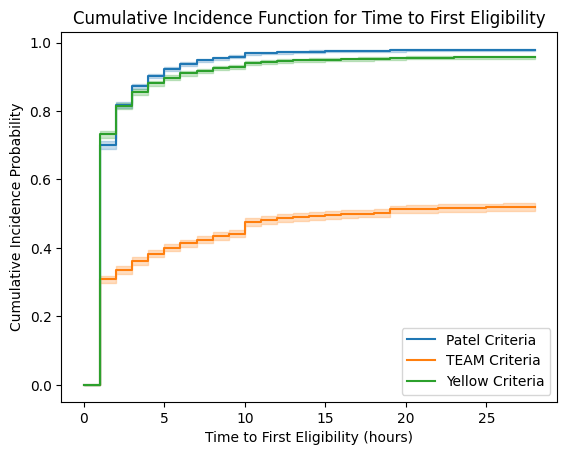

Median time to first eligibility (Patel): 1.0 hours
Median time to first eligibility (TEAM): 17.0 hours
Median time to first eligibility (Yellow): 1.0 hours
Cumulative Incidence Function value at time = 1 (Patel): 70%
Cumulative Incidence Function value at time = 1 (TEAM): 31%
Cumulative Incidence Function value at time = 1 (Yellow): 73%


In [23]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


from lifelines import KaplanMeierFitter

# Initialize the KaplanMeierFitter for Patel, TEAM and Yellow criteria
kmf_patel = KaplanMeierFitter()
kmf_team = KaplanMeierFitter()
kmf_yellow = KaplanMeierFitter()

# fit the data for Patel criteria
kmf_patel.fit(durations=survival_analysis_df_patel['time_to_first_eligibility'], event_observed=survival_analysis_df_patel['eligible'], label='Patel Criteria')

# Fit the data for TEAM criteria
kmf_team.fit(durations=survival_analysis_df_team['time_to_first_eligibility'], event_observed=survival_analysis_df_team['eligible'], label='TEAM Criteria')

# Fit the data for Yellow criteria
kmf_yellow.fit(durations=survival_analysis_df_yellow['time_to_first_eligibility'], event_observed=survival_analysis_df_yellow['eligible'], label='Yellow Criteria')

# Plot the cumulative incidence function for all criteria
ax = kmf_patel.plot_cumulative_density()
kmf_team.plot_cumulative_density(ax=ax)
kmf_yellow.plot_cumulative_density(ax=ax)

plt.title('Cumulative Incidence Function for Time to First Eligibility')
plt.xlabel('Time to First Eligibility (hours)')
plt.ylabel('Cumulative Incidence Probability')
plt.legend()
plt.show()

# Estimate the median time to first eligibility for all criteria
median_time_to_first_eligibility_patel = kmf_patel.median_survival_time_
median_time_to_first_eligibility_team = kmf_team.median_survival_time_
median_time_to_first_eligibility_yellow = kmf_yellow.median_survival_time_

print(f"Median time to first eligibility (Patel): {median_time_to_first_eligibility_patel} hours")
print(f"Median time to first eligibility (TEAM): {median_time_to_first_eligibility_team} hours")
print(f"Median time to first eligibility (Yellow): {median_time_to_first_eligibility_yellow} hours")

# Calculate the cumulative incidence function value at time = 1 for all criteria
cif_value_at_1_patel = 1 - kmf_patel.predict(1)
cif_value_at_1_team = 1 - kmf_team.predict(1)
cif_value_at_1_yellow = 1 - kmf_yellow.predict(1)

print(f"Cumulative Incidence Function value at time = 1 (Patel): {cif_value_at_1_patel:.0%}")
print(f"Cumulative Incidence Function value at time = 1 (TEAM): {cif_value_at_1_team:.0%}")
print(f"Cumulative Incidence Function value at time = 1 (Yellow): {cif_value_at_1_yellow:.0%}")